In [95]:
import torch
import numpy as np
import os
import sys 

# Add the test directory to sys.path
parent_dir = os.path.expanduser('..')
sys.path.append(parent_dir)
importlib.reload(importlib.import_module('evaluation.networks'))

from toy_models.train import TrainModel
from evaluation.networks import DrawNeuralNetwork

device = 'cuda'


In [149]:
# Remember to login to wandb!
!wandb login ${WANDB_API}

import sys
import os 

# Add the test directory to sys.path
parent_dir = os.path.expanduser('..')
sys.path.append(parent_dir)



# Standard library imports
import importlib
import gc
import copy

# Third-party imports
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import einops
import matplotlib.pyplot as plt
from transformers import GPT2Model, GPT2Config, GPT2Tokenizer
from datasets import load_dataset
from transformer_lens.utils import tokenize_and_concatenate
import wandb


# Reload modules using importlib
importlib.reload(importlib.import_module('eigenestimation.eigenhora'))
importlib.reload(importlib.import_module('eigenestimation.loss'))
importlib.reload(importlib.import_module('eigenestimation.train'))
importlib.reload(importlib.import_module('evaluation.examples'))
importlib.reload(importlib.import_module('evaluation.networks'))

importlib.reload(importlib.import_module('toy_models.tms'))
importlib.reload(importlib.import_module('eigenestimation.utils'))



from eigenestimation.eigenhora import EigenHora
from eigenestimation import loss
from eigenestimation.train import Train
from evaluation.examples import TopActivatingSamples 
from evaluation.networks import DrawNeuralNetwork

from toy_models import tms
from eigenestimation.utils import TransformDataLoader, DeleteParams, RetrieveWandBArtifact

device = 'cuda'

wandb: Currently logged in as: brianna-chrisman (brianna-chrisman-2024). Use `wandb login --relogin` to force relogin


In [141]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ReluNetwork(nn.Module):
    def __init__(self, input_size, output_size, num_layers, neurons_per_layer):
        super(ReluNetwork, self).__init__()
        
        self.layers = nn.ModuleList()  # List to hold layers
        
        # Input layer
        self.layers.append(nn.Linear(input_size, neurons_per_layer))
        self.layers[-1].weight.data.normal_(0, 0.1)
        self.layers[-1].bias.data.zero_()
        
        # Hidden layers
        for i in range(1, num_layers):  # num_layers-1 hidden layers
            layer = nn.Linear(neurons_per_layer, neurons_per_layer)
            layer.weight.data.normal_(0, 0.1)
            layer.bias.data.zero_()
            self.layers.append(layer)
        
        # Output layer
        output_layer = nn.Linear(neurons_per_layer, output_size)
        output_layer.weight.data.normal_(0, 0.1)
        output_layer.bias.data.zero_()
        self.layers.append(output_layer)
        

    
    def forward(self, x):
        """
        Forward pass of the network.
        """
        for i, layer in enumerate(self.layers[:-1]):
            x = layer(x)       # Linear transformation
            x = F.relu(x)      # ReLU activation
        
        x = self.layers[-1](x)  # Final layer (output layer, no activation)
        return x


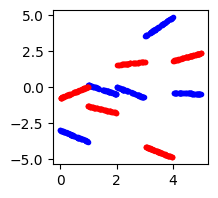

In [ ]:
def Generate(n_inputs, n_polytopes, n_samples):
    lookup_dict = dict()
    for input_node in range(n_inputs):
        lookup_dict[input_node] = {n:(np.random.randn(),np.random.randn())  for n in range(n_polytopes)}

    X = n_polytopes*torch.rand((n_samples, n_inputs))

    # Lookup dict on each element of X
    y = torch.zeros_like(X)

    for row in range(y.shape[0]):
        for column in range(y.shape[1]):
            m = lookup_dict[column][round(X[row, column].item()-.5)][0]
            b = lookup_dict[column][round(X[row, column].item()-.5)][1]
            y[row, column] = (m*X[row, column] + b)
    return X, y

X, y = Generate(n_inputs=4, n_polytopes=4, 300)

eigen_X = X[:100].to(device)
model_dataloader = DataLoader(TensorDataset(X[100:200].to(device), y[100:200].to(device)), batch_size=8, shuffle=True)
eval_X = X[200:].to(device)

plt.figure(figsize=(2,2))
plt.plot(X[:,0].numpy(), y[:,0].numpy(), 'b.')
plt.plot(X[:,1].numpy(), y[:,1].numpy(), 'r.')



In [266]:
learning_rate = .001
relu_network = ReluNetwork(n_inputs, n_inputs, 5, 5).to(device)
_, _, _ = TrainModel(relu_network, nn.MSELoss(), learning_rate, model_dataloader, n_epochs=2000, device=device)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (8x3 and 2x5)

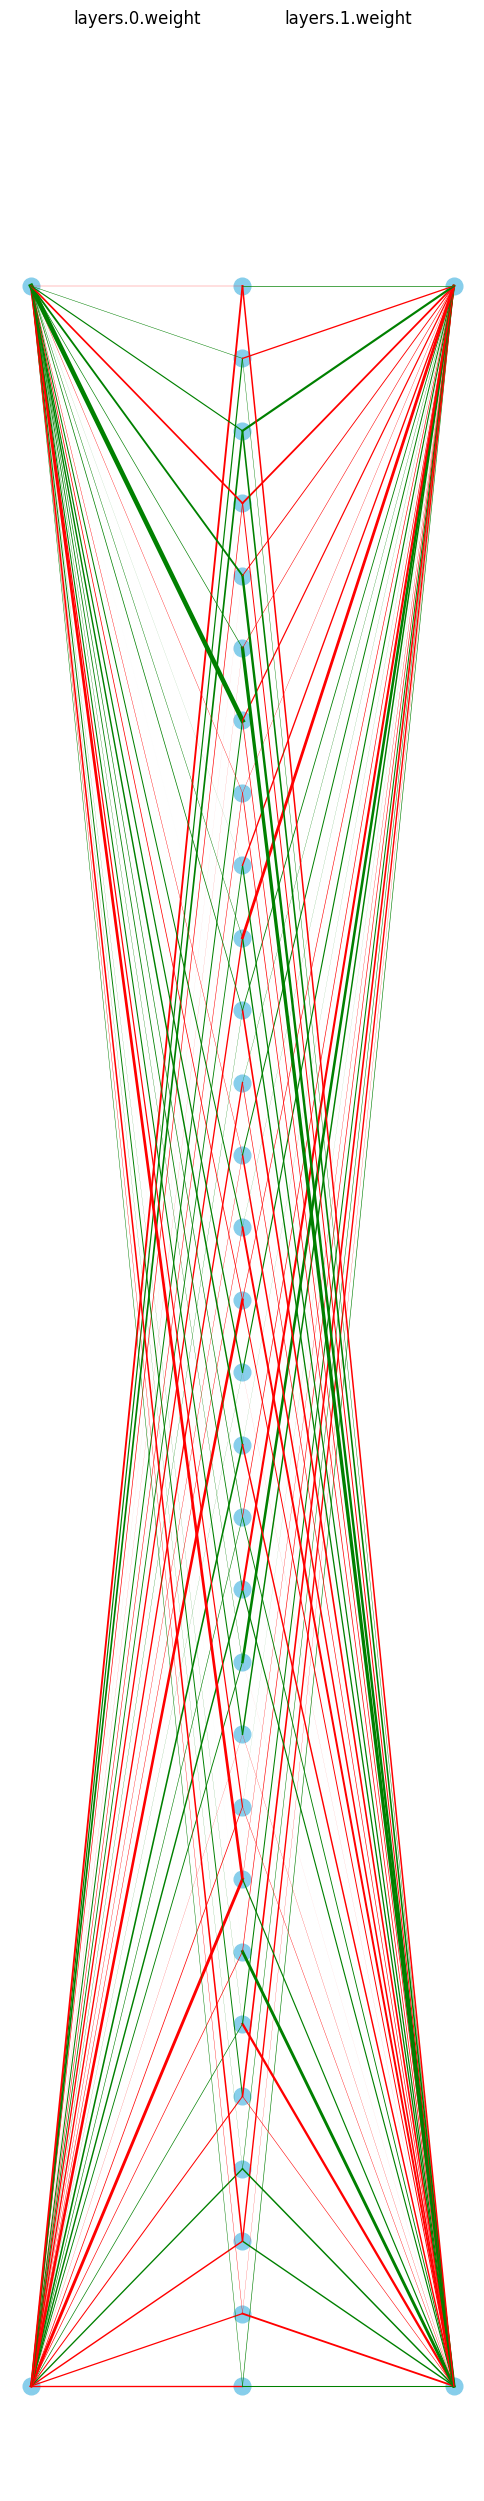

In [259]:
DrawNeuralNetwork({name:param.transpose(0,1) for name,param in relu_network.named_parameters() if 'weight' in name})

In [264]:
def model0(y):
    return torch.zeros_like(y)


hora_features = 4
hora_rank = 1

DeleteParams(relu_network, [name for name, param in relu_network.named_parameters() if 'bias' in name])

eigenmodel = EigenHora(relu_network, model0, loss.MSELoss(), hora_features, hora_rank, device=device).to(device)
dataloader = TransformDataLoader(eigen_X, batch_size=16, transform_fn=eigenmodel.compute_jacobian)

eval_dataloader = TransformDataLoader(eval_X, batch_size=16, transform_fn=eigenmodel.compute_jacobian)

project_name = 'eigenestimation'
run_name = 'polytopes'

Train(eigenmodel, dataloader, lr=.01, n_epochs=100, L0_penalty=.1, device=device, project_name=project_name, run_name=run_name,
      eval_fns={TopActivatingSamples:[3, None, True]}, eval_dataloader=eval_dataloader) 


Epoch 0 : 808.180,  Reconstruction Loss: 807.126,  Sparsity Loss: 10.542
Epoch 10 : 106.803,  Reconstruction Loss: 102.235,  Sparsity Loss: 45.678
Epoch 20 : 57.569,  Reconstruction Loss: 52.458,  Sparsity Loss: 51.114
Epoch 30 : 50.205,  Reconstruction Loss: 45.163,  Sparsity Loss: 50.425
Epoch 40 : 55.822,  Reconstruction Loss: 50.630,  Sparsity Loss: 51.919
Epoch 50 : 50.198,  Reconstruction Loss: 45.112,  Sparsity Loss: 50.858
Epoch 60 : 49.304,  Reconstruction Loss: 43.945,  Sparsity Loss: 53.593
Epoch 70 : 47.144,  Reconstruction Loss: 41.985,  Sparsity Loss: 51.591
Epoch 80 : 52.197,  Reconstruction Loss: 46.966,  Sparsity Loss: 52.306
Epoch 90 : 46.730,  Reconstruction Loss: 41.668,  Sparsity Loss: 50.617
evaluating...
TopActivatingSamples
------feature 0-------
tensor([0.1679, 1.7668], device='cuda:0') -> 47.07756042480469
tensor([0.1240, 1.5195], device='cuda:0') -> 43.18817138671875
tensor([0.4182, 1.7848], device='cuda:0') -> 42.91853713989258
------feature 1-------
tensor(

reconstruction_loss,█▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sparsity_loss,▁▄▄▄▃▅▇▇▇▇▇██▇▇▇▆▇██▆▇▇█▇▆▆▆▆▇▇▆▇▇▆▆█▆▇▇
total_loss,█▇▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reconstruction_loss,46.35129
sparsity_loss,51.28375
total_loss,51.47966


In [202]:
X.max()

tensor(9.9972)

In [260]:
relu_network(X[:10].to(device))


tensor([[ 0.0892,  1.4675],
        [-0.2987,  0.4318],
        [-0.9333,  1.1244],
        [-1.8098, -0.9753],
        [-0.9716, -0.5482],
        [-0.5506, -0.4602],
        [-1.3136, -1.1568],
        [ 0.2356,  1.5155],
        [-0.1593, -0.7080],
        [-1.2612, -1.1151]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [247]:
y[:10]

tensor([[-4.1520, -4.6231],
        [ 3.4503, -0.2477],
        [ 1.4535, -0.1433],
        [ 1.5552, -4.6806],
        [ 3.2113, -0.4028],
        [ 1.9798,  0.2410],
        [ 1.8875, -0.0599],
        [ 0.3831, -0.2572],
        [ 1.1083,  4.5774],
        [ 2.0612, -5.1248]])

In [177]:
eigen_X

tensor([[4.8332, 1.3817],
        [5.8175, 0.6344],
        [0.8402, 6.1701],
        ...,
        [6.9978, 6.7152],
        [0.7191, 4.3476],
        [5.4998, 1.6173]], device='cuda:0')

In [176]:
list(relu_network.named_parameters())

[('layers.0.weight',
  Parameter containing:
  tensor([[  0.8752,   0.3243],
          [-30.8162, -32.6857],
          [ -1.4177,  -1.5459],
          [-34.9919, -36.8150],
          [ -0.5908,  -0.5726]], device='cuda:0', requires_grad=True)),
 ('layers.1.weight',
  Parameter containing:
  tensor([[ -0.6966,   0.1999,   1.6305,  -2.0645,   0.3573],
          [ -7.3872,  -4.2244,  -1.7123, -28.3286,  -0.1223],
          [ -5.7058,  -2.2890,  -0.8930, -20.3211,  -0.8915],
          [ -0.0411,  -1.3963,  -0.4578,  -0.6275,  -0.3870],
          [ -3.1068,  -2.6741,   0.0732, -13.7423,  -1.8940]], device='cuda:0',
         requires_grad=True)),
 ('layers.2.weight',
  Parameter containing:
  tensor([[ -0.9197,  52.0676,  20.5919,  -1.0648,   2.8011],
          [ -1.4208, -40.1410, -17.8399,  -1.9434,  -3.2662]], device='cuda:0',
         requires_grad=True))]

In [135]:
DeleteParams(relu_network, [name for name, param in relu_network.named_parameters() if 'bias' in name])

list(relu_network.named_parameters())

[('layer0_weights',
  Parameter containing:
  tensor([[ 0.1921,  0.1668,  0.0951],
          [-0.3046, -0.4316, -0.1178],
          [ 0.1476, -0.9794, -0.1671],
          [-0.2868, -0.9900,  0.3786],
          [-2.4300, -0.9379, -0.8424]], device='cuda:0', requires_grad=True)),
 ('layer1_weights',
  Parameter containing:
  tensor([[-1.5729, -0.0173,  1.7244, -0.4600, -0.7593],
          [ 0.0721, -0.1065,  0.2813,  0.8674, -0.7369],
          [-1.0593, -0.9422,  1.1805, -0.0550,  0.3111],
          [ 1.4218,  0.9278, -0.0334,  0.9506,  0.1906],
          [-1.7042, -0.6912,  0.2461, -0.3007,  0.9132]], device='cuda:0',
         requires_grad=True)),
 ('layer2_weights',
  Parameter containing:
  tensor([[ 0.8720, -1.2430, -0.4042,  0.1784,  1.0002],
          [-1.5385, -0.6805,  0.3094, -0.2575, -0.3639],
          [-1.9710, -0.4408, -0.7819,  0.2534, -1.9844]], device='cuda:0',
         requires_grad=True)),
 ('layers.0.bias',
  Parameter containing:
  tensor([ 0.4281, -1.0083,  0.2569,

In [136]:
[name for name, param in relu_network.named_parameters() if 'bias' in name]

['layers.0.bias', 'layers.1.bias', 'layers.2.bias']

In [121]:
np.array([0,1,2,3])[-2:0:-1]

array([2, 1])

In [108]:
eigenmodel(j)

RuntimeError: einsum(): subscript c has size 5 for operand 1 which does not broadcast with previously seen size 16

In [112]:
for name, param in eigenmodel.low_rank.items():
    print(name, param.shape)

AttributeError: 'list' object has no attribute 'shape'

In [118]:
eigenmodel.low_rank['layer0_weights'][1].shape

torch.Size([3, 1, 15])

In [106]:
j['layer0_weights'].shape

torch.Size([16, 5, 3])